In [1]:
import os
import random
from abc import abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as F1
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, transforms
from tqdm import tqdm
from types_ import *
from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim_skimage

In [2]:
class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size: int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [3]:
class PairedTopoDataset(Dataset):
    def __init__(self, image_dir, topo_dir, transform):
        """
        Args:
            image_dir (str): Папка с обычными изображениями (без `_topo`).
            topo_dir (str): Папка с топо-изображениями (с `_topo`).
            transform (callable, optional): Дополнительные аугментации.
        """
        self.image_dir = image_dir
        self.topo_dir = topo_dir
        self.transform = transform
        self.to_tensor = ToTensor()  # Конвертирует PIL → Tensor и нормализует в [0, 1]

        # Собираем все файлы и находим пары (image, topo)
        self.pairs = self._find_paired_files()

    def _extract_base_and_number(self, filename):
        """Извлекает базовое имя и номер из названия файла.
        Пример:
            "cor_000_Pomona_..._0.png" → ("cor_000_Pomona_...", 0)
            "cor_000_Pomona_..._topo_5.png" → ("cor_000_Pomona_...", 5)
        """
        # Удаляем расширение (.png, .jpg и т.д.)
        name_without_ext = os.path.splitext(filename)[0]

        # Разделяем имя и номер (последнее `_число`)
        parts = name_without_ext.rsplit("_", 1)
        if len(parts) != 2:
            return None, None  # Неправильный формат

        base_part, number_str = parts
        if not number_str.isdigit():
            return None, None  # Последняя часть — не число

        # Если в названии есть `_topo`, убираем его из базовой части
        if "_topo" in base_part:
            base_part = base_part.replace("_topo", "")

        return base_part, int(number_str)

    def _find_paired_files(self):
        """Находит все пары (image, topo) с одинаковыми base_name и номером."""
        # Собираем все файлы из image_dir и topo_dir
        image_files = os.listdir(self.image_dir)
        topo_files = os.listdir(self.topo_dir)

        # Создаем словарь: { (base_name, number) → {"image": path, "topo": path} }
        pairs_dict = {}

        # Обрабатываем обычные изображения (без `_topo`)
        for img_file in image_files:
            base, num = self._extract_base_and_number(img_file)
            if base is None:
                continue  # Пропускаем файлы с неправильным форматом
            key = (base, num)
            if key not in pairs_dict:
                pairs_dict[key] = {"image": None, "topo": None}
            pairs_dict[key]["image"] = os.path.join(self.image_dir, img_file)

        # Обрабатываем топо-изображения (с `_topo`)
        for topo_file in topo_files:
            base, num = self._extract_base_and_number(topo_file)
            if base is None:
                continue
            key = (base, num)
            if key not in pairs_dict:
                continue  # Нет пары в image_dir → пропускаем
            pairs_dict[key]["topo"] = os.path.join(self.topo_dir, topo_file)

        # Оставляем только полные пары (где есть и image, и topo)
        valid_pairs = []
        for key in pairs_dict:
            if pairs_dict[key]["image"] and pairs_dict[key]["topo"]:
                img_name = os.path.basename(pairs_dict[key]["image"])
                topo_name = os.path.basename(pairs_dict[key]["topo"])
                valid_pairs.append(
                    (
                        pairs_dict[key]["image"],  # путь к обычному изображению
                        pairs_dict[key]["topo"],  # путь к топо-изображению
                        img_name,  # имя файла обычного изображения
                        topo_name,  # имя файла топо-изображения
                    )
                )
        return valid_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, topo_path, img_name, topo_name = self.pairs[idx]
    
    # Загружаем изображения
        img = Image.open(img_path).convert("L")
        topo = Image.open(topo_path).convert("L")

        # # Уменьшаем разрешение в 50 раз
        # new_size = (
        #     int(img.width / 50),
        #     int(img.height / 50),
        # )
        # img = img.resize(new_size, Image.Resampling.LANCZOS)
        # topo = topo.resize(new_size, Image.Resampling.LANCZOS)

        # Конвертируем в numpy и нормализуем
        img = np.array(img).astype(np.float32) / 255
        topo = np.array(topo).astype(np.float32) / 255

        # Преобразуем в тензоры [1, H, W]
        img_tensor = self.to_tensor(img)
        topo_tensor = self.to_tensor(topo)
        
        # Применяем аугментации
        img_tensor = self.transform(img_tensor)
        topo_tensor = self.transform(topo_tensor)

#         # Объединяем по каналам → [2, H, W]
#         combined = torch.cat((img_tensor, topo_tensor), dim=0)

#         # Применяем аугментации
#         if self.transform:
#             combined = self.transform(combined)

        return img_tensor, img_name

In [4]:
class VanillaVAE(BaseVAE):

    def __init__(
        self, in_channels: int, latent_dim: int, hidden_dims: List = None, **kwargs
    ) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim
            # in_channels = 2

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 16 * 16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 16 * 16, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 16 * 16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=3, padding=1),
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        # print(f"Encoder output shape: {result.shape}")
        result = torch.flatten(result, start_dim=1)
        # print(f"Flattened shape: {result.shape}")

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 16, 16)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        def mssim_loss(recons, target):
            return 1 - ms_ssim(recons, target, data_range=1.0, size_average=True)

        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        log_var = torch.clamp(log_var, min=-10, max=10)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )
        kld_weight = 0.0001

        recons_loss = F.mse_loss(recons, input[:,0,:,:].unsqueeze(1))
        # recons_loss = F.mse_loss(recons, input[:,0,:,:])
        recons_weight = 0.8
        
        mssim = mssim_loss(recons, input[:, 0, :, :].unsqueeze(1))
        # mssim = mssim_loss(recons, input[:, 0, :, :])
        mssim_weight = 1 - recons_weight

        loss = recons_loss * recons_weight + kld_loss * kld_weight + mssim * mssim_weight
        
        # loss = recons_loss * recons_weight
        return {"loss": loss, "Reconstruction_Loss": recons_loss, "KLD": kld_loss, "MSSIM": mssim}
        # return {"loss": loss, "Reconstruction_Loss": recons_loss}

    def sample(self, num_samples: int, current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples, self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [5]:
# # Определим аугментации
# class Random90Rotation:
#     """Случайный поворот на угол, кратный 90 градусам (0, 90, 180, 270)"""

#     def __call__(self, img):
#         angle = random.choice([0, 90, 180, 270])
#         return F1.rotate(img, angle)


augmentations = transforms.Compose(
    [
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ],
)

In [6]:
dataset = PairedTopoDataset(
    image_dir=r"/home/jupyter/datasphere/filestore/tyles/images",  # папка с обычными изображениями
    topo_dir=r"/home/jupyter/datasphere/filestore/tyles/topo",  # папка с топо-изображениями
    transform=augmentations,
)

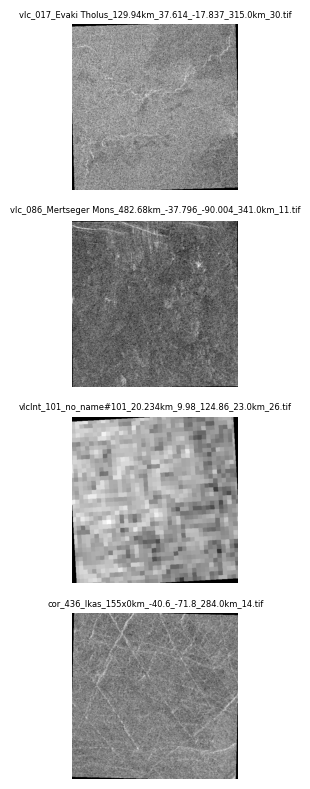

In [7]:
batch_size = 64
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, num_workers=8
)

batch, img_names = next(iter(dataloader))

plt.figure(figsize=(12, 8))
for i in range(4):
    # Берем i-й пример из батча
    img_pair = batch[i]

    # Разделяем каналы
    img = img_pair[0].numpy().squeeze()
    # print(img.shape)

    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{img_names[i]}", fontsize=6)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaVAE(in_channels=1, latent_dim=1024).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 52

In [12]:
# Загрузка весов
weights_path = '/home/jupyter/datasphere/project/vanilla_vae_LP1024_weights100.pth'
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [ ]:
# Создаем списки для хранения значений потерь
train_loss_history = []
recon_loss_history = []
kld_loss_history = []
mssim_loss_history = []

# Общий прогресс по эпохам
epoch_progress = tqdm(range(num_epochs), desc="Training", position=0)

# num_batches_to_process = 20
    
for epoch in epoch_progress:
    model.train()
    epoch_train_loss = 0
    epoch_recon_loss = 0
    epoch_kld_loss = 0
    epoch_mssim_loss = 0

    # print(f"Epoch {epoch + 1}")
    # i = 0
    
    # processed_batches = 0

    for batch in dataloader:
        # if processed_batches >= num_batches_to_process:
        #     break
    
        x = batch[0].to(device)  # [B, 2, H, W]
        optimizer.zero_grad()
        recon_batch, input_batch, mu, logvar = model(x)
        
        loss_dict = model.loss_function(recon_batch, input_batch, mu, logvar)

        loss = loss_dict["loss"]
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Подрезка градиентов

        # Проверка градиентов
        # total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float('inf'))
        # print(f"Gradient norm: {total_norm}")

        optimizer.step()

        # Собираем статистику по потерям
        epoch_train_loss += loss.item()
        epoch_recon_loss += loss_dict["Reconstruction_Loss"].item()
        epoch_kld_loss += loss_dict["KLD"].item()
        epoch_mssim_loss += loss_dict["MSSIM"].item()
        # processed_batches += 1

        
        # i += 1
        # if i == 1:
        #     break
        
#     # Нормализуем по количеству обработанных батчей
#     epoch_train_loss /= num_batches_to_process
#     epoch_kld_loss /= num_batches_to_process
#     epoch_recon_loss /= num_batches_to_process
#     epoch_mssim_loss /= num_batches_to_process
    
#     train_loss_history.append(epoch_train_loss)
#     recon_loss_history.append(epoch_recon_loss)
#     kld_loss_history.append(epoch_kld_loss)
#     mssim_loss_history.append(epoch_mssim_loss)
    
#     epoch_progress.set_postfix({
#         "Epoch Loss": f"{epoch_train_loss:.4f}",
#         "Recon": f"{epoch_recon_loss:.4f}",
#         "KLD": f"{epoch_kld_loss:.4f}",
#         "MSSIM": f"{epoch_mssim_loss:.4f}",
#     })

    # Нормализуем по количеству батчей
    num_batches = len(dataloader)
    epoch_train_loss /= num_batches
    epoch_recon_loss /= num_batches
    epoch_kld_loss /= num_batches
    epoch_mssim_loss /= num_batches

    # Сохраняем значения для графиков
    train_loss_history.append(epoch_train_loss)
    recon_loss_history.append(epoch_recon_loss)
    kld_loss_history.append(epoch_kld_loss)
    mssim_loss_history.append(epoch_mssim_loss)

    # Обновляем описание прогресса эпох
    epoch_progress.set_postfix(
        {
            "Epoch Loss": f"{epoch_train_loss:.4f}",
            "Recon": f"{epoch_recon_loss:.4f}",
            "KLD": f"{epoch_kld_loss:.4f}",
            "MSSIM": f"{epoch_mssim_loss:.4f}",
        }
    )

    # Сохраняем веса модели в файл .pth
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"vanilla_vae_LP1024_weights{epoch+50}.pth")
        print(f"Weights saved to 'vanilla_vae_LP1024_weights{epoch+50}.pth'")

# Закрываем прогресс эпох
epoch_progress.close()

Training:   2%|▏         | 1/52 [14:10<12:02:39, 850.19s/it, Epoch Loss=0.1432, Recon=0.0122, KLD=98.6301, MSSIM=0.6180]

Weights saved to 'vanilla_vae_LP1024_weights50.pth'


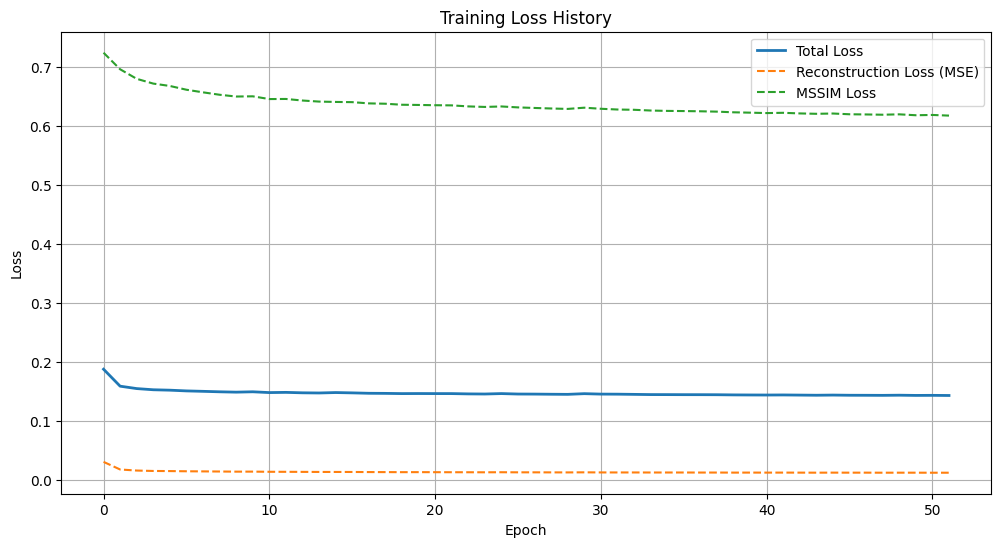

In [13]:
# Визуализация графиков потерь без KLD
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label="Total Loss", linewidth=2)
plt.plot(recon_loss_history, label="Reconstruction Loss (MSE)", linestyle="--")
plt.plot(mssim_loss_history, label="MSSIM Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)
plt.show()

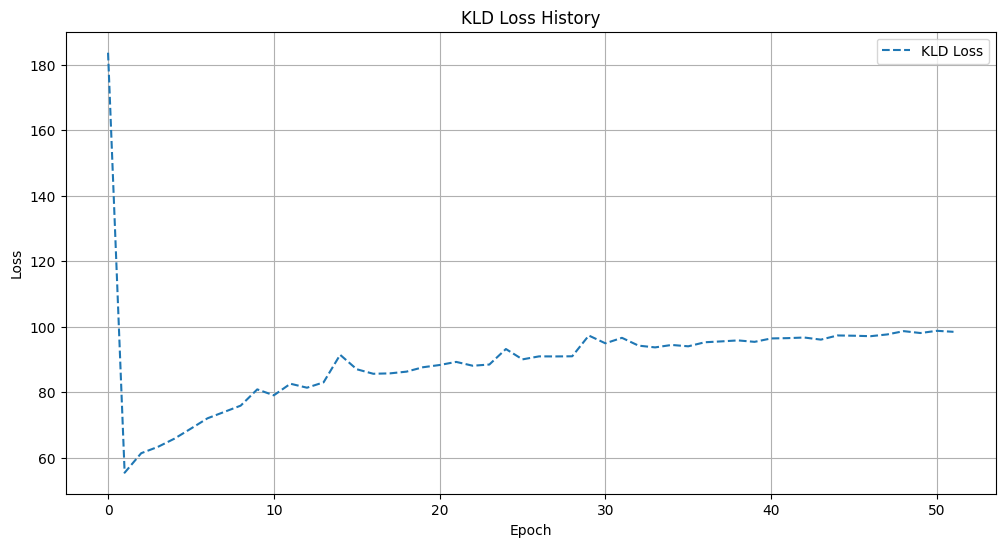

In [14]:
# Визуализация графика KLD
plt.figure(figsize=(12, 6))
plt.plot(kld_loss_history, label="KLD Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("KLD Loss History")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.eval()

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

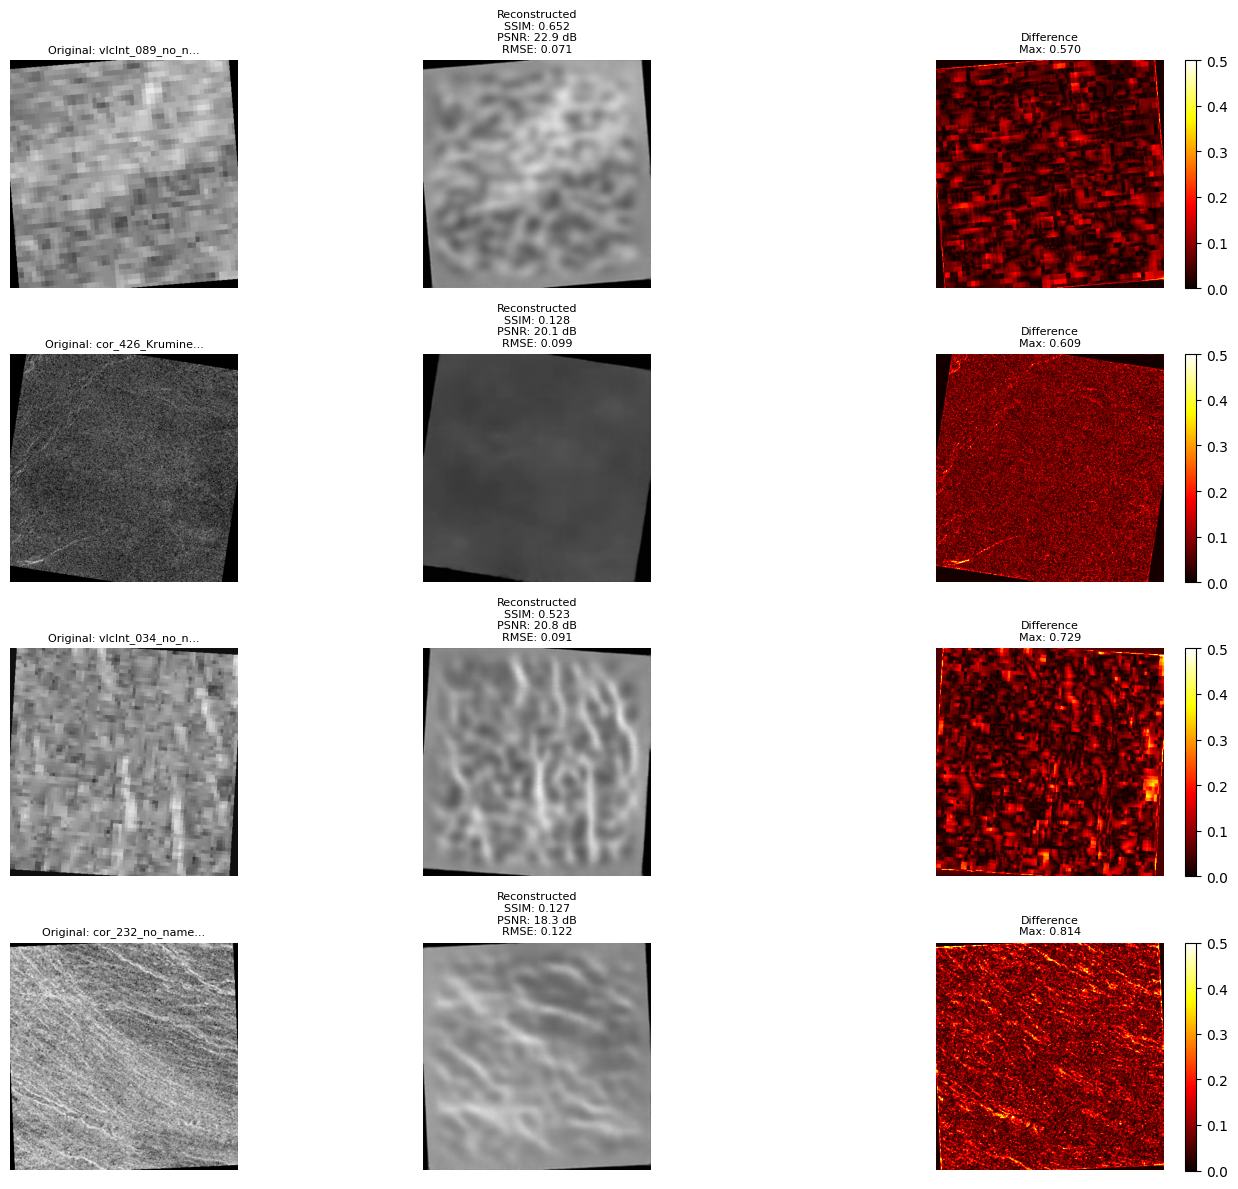


Средние значения метрик по всем изображениям:
SSIM: 0.3575
PSNR: 20.53
RMSE: 0.0958
Максимальная разница: 0.6807


In [15]:
def calculate_rmse(img1, img2):
    return np.sqrt(np.mean((img1 - img2) ** 2))

with torch.no_grad():
    num_images = 4
    plt.figure(figsize=(14, 3 * num_images))
    
    # Инициализация списков для хранения метрик
    ssim_values = []
    psnr_values = []
    rmse_values = []
    max_diff_values = []
    
    random_indices = random.sample(range(len(dataset)), num_images)
    
    for i in range(num_images):
        idx = random_indices[i]
        x, img_name = dataset[idx]
        x = x.unsqueeze(0).to(device)

        recon_x, _, _, _ = model(x)
        
        original = x[0].cpu().numpy().squeeze()
        reconstructed = recon_x[0].cpu().numpy().squeeze()
        
        if original.ndim == 3:
            original_metric = original.transpose(1, 2, 0)
            reconstructed_metric = reconstructed.transpose(1, 2, 0)
        else:
            original_metric = original
            reconstructed_metric = reconstructed
        
        try:
            ssim_val = ssim_skimage(original_metric, reconstructed_metric,
                                  data_range=1.0, channel_axis=-1 if original_metric.ndim == 3 else None)
            psnr_val = psnr(original_metric, reconstructed_metric, data_range=1.0)
            rmse_val = calculate_rmse(original_metric, reconstructed_metric)
        except Exception as e:
            print(f"Error calculating metrics for {img_name}: {str(e)}")
            ssim_val, psnr_val, rmse_val = -1, -1, -1
        
        # Сохраняем значения метрик
        ssim_values.append(ssim_val)
        psnr_values.append(psnr_val)
        rmse_values.append(rmse_val)
        
        # Визуализация
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(original[0] if original.ndim == 3 else original, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Original: {img_name[:15]}...", fontsize=8)
        plt.axis('off')

        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(reconstructed[0] if reconstructed.ndim == 3 else reconstructed, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Reconstructed\nSSIM: {ssim_val:.3f}\nPSNR: {psnr_val:.1f} dB\nRMSE: {rmse_val:.3f}", 
                 fontsize=8)
        plt.axis('off')
        
        plt.subplot(num_images, 3, 3*i + 3)
        difference = np.abs(
            (original[0] if original.ndim == 3 else original) - 
            (reconstructed[0] if reconstructed.ndim == 3 else reconstructed))
        plt.imshow(difference, cmap='hot', vmin=0, vmax=0.5)
        plt.title(f"Difference\nMax: {difference.max():.3f}", fontsize=8)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
    # Вычисляем максимальную разницу для этого изображения
        difference = np.abs(
            (original[0] if original.ndim == 3 else original) - 
            (reconstructed[0] if reconstructed.ndim == 3 else reconstructed))
        max_diff_values.append(difference.max())
        
    plt.tight_layout()
    plt.savefig('reconstructions_with_metrics_LP1024.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Вычисляем средние значения метрик
    avg_ssim = np.mean(ssim_values)
    avg_psnr = np.mean(psnr_values)
    avg_rmse = np.mean(rmse_values)
    avg_max_diff = np.mean(max_diff_values)
    
    # Выводим средние значения
    print("\nСредние значения метрик по всем изображениям:")
    print(f"SSIM: {avg_ssim:.4f}")
    print(f"PSNR: {avg_psnr:.2f}")
    print(f"RMSE: {avg_rmse:.4f}")
    print(f"Максимальная разница: {avg_max_diff:.4f}")